In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# 加载数据

In [2]:
cols = ['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9',
       'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25',
       'C26']

In [3]:
data = pd.read_table('/Users/Nelson/Desktop/dac/train.txt', nrows=600000, header=None, names=cols)

In [4]:
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


# 数据预处理

## 定义特征组

In [5]:
dense_feats = [f for f in cols if f[0] == "I"]
sparse_feats = [f for f in cols if f[0] == "C"]

## 处理dense特征

In [6]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [7]:
data_dense = process_dense_feats(data, dense_feats)

## 处理sparse特征

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [10]:
data_sparse = process_sparse_feats(data, sparse_feats)

In [11]:
total_data = pd.concat([data_dense, data_sparse], axis=1)

In [12]:
total_data['label'] = data['label']

# AutoInt

## embedding层

### dense特征

In [13]:
import tensorflow as tf

In [14]:
k=8

In [15]:
dense_inputs = []
for f in dense_feats:
    _input = Input([1], name=f)
    dense_inputs.append(_input)

In [16]:
dense_inputs

[<tf.Tensor 'I1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I4:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I5:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I7:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I8:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I9:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I10:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I11:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I12:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I13:0' shape=(None, 1) dtype=float32>]

In [17]:
dense_kd_embed = []
for i, _input in enumerate(dense_inputs):
    f = dense_feats[i]
    embed = tf.Variable(tf.random.truncated_normal(shape=(1, k), stddev=0.01), name=f)
    scaled_embed = tf.expand_dims(_input * embed, axis=1)
    dense_kd_embed.append(scaled_embed)

In [18]:
dense_kd_embed

[<tf.Tensor 'ExpandDims:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_1:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_2:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_3:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_4:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_5:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_6:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_7:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_8:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_9:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_10:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_11:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'ExpandDims_12:0' shape=(None, 1, 8) dtype=float32>]

### sparse特征

In [19]:
sparse_inputs = []
for f in sparse_feats:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)

In [20]:
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_feats[i]
    voc_size = data[f].nunique()
    _embed = Embedding(voc_size+1, k, embeddings_regularizer=tf.keras.regularizers.l2(0.5))(_input)
    sparse_kd_embed.append(_embed)

In [21]:
sparse_kd_embed

[<tf.Tensor 'embedding/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_1/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_2/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_3/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_4/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_5/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_6/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_7/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_8/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_9/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_10/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_11/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_12/Identity:0' shape=(None, 1, 8) dtype=float32>,
 <tf.Tensor 'embedding_13/Identity:0' shape=(None, 1, 8) dtype=

In [22]:
input_embeds = dense_kd_embed + sparse_kd_embed

##  Interacting Layer

In [23]:
# 构建feature map
embed_map = Concatenate(axis=1)(input_embeds)  # ?, 39, 8

In [32]:
def auto_interacting(embed_map, d=8, n_attention_head=3):
    """
    实现单层 AutoInt Interacting Layer
    @param embed_map: 输入的embedding feature map, (?, n_feats, n_dim)
    @param d: Q,K,V映射后的维度
    @param n_attention_head: multi-head attention的个数
    """
    assert len(embed_map.shape) == 3, "Input embedding feature map must be 3-D tensor."
    
    k = embed_map.shape[-1]
    
    attention_heads = []
    W_Q = []
    W_K = []
    W_V = []
    for i in range(n_attention_head):
        # 初始化W_Q, W_K, W_V
        W_Q.append(tf.Variable(tf.random.truncated_normal(shape=(k, d)), name="query_"+str(i)))  # k, d
        W_K.append(tf.Variable(tf.random.truncated_normal(shape=(k, d)), name="key_"+str(i)))  # k, d
        W_V.append(tf.Variable(tf.random.truncated_normal(shape=(k, d)), name="value_"+str(i)))  # k, d
     
    for i in range(n_attention_head):
        # 映射到d维空间
        embed_q = tf.matmul(embed_map, W_Q[i])  # ?, 39, d
        embed_k = tf.matmul(embed_map, W_K[i])  # ?, 39, d
        embed_v = tf.matmul(embed_map, W_V[i])  # ?, 39, d
    
        # 计算attention
        energy = tf.matmul(embed_q, tf.transpose(embed_k, [0, 2, 1]))  # ?, 39, 39
        attention = tf.nn.softmax(energy)  # ?, 39, 39
    
        attention_output = tf.matmul(attention, embed_v)  # ?, 39, d
        attention_heads.append(attention_output)
#     return attention_heads
    
    print(attention_heads)
    # concat multi head
    multi_attention_output = Concatenate(axis=-1)(attention_heads)  # ?, 39, n_attention_head*d
    
    # ResNet
    w_res = tf.Variable(tf.random.truncated_normal(shape=(k, d*n_attention_head)), name="w_res_"+str(i))  # k, d*n_attention_head
    output = Activation("relu")(multi_attention_output + tf.matmul(embed_map, w_res))  # ?, 39, d*n_attention_head)
    
    return output

In [34]:
def build_autoint(x0, n_layers):
    xl = x0
    for i in range(n_layers):
        xl = auto_interacting(xl)
    
    return xl

In [36]:
autoint_layer = build_autoint(embed_map, 3)

[<tf.Tensor 'MatMul_81:0' shape=(None, 39, 8) dtype=float32>, <tf.Tensor 'MatMul_86:0' shape=(None, 39, 8) dtype=float32>, <tf.Tensor 'MatMul_91:0' shape=(None, 39, 8) dtype=float32>]
[<tf.Tensor 'MatMul_97:0' shape=(None, 39, 8) dtype=float32>, <tf.Tensor 'MatMul_102:0' shape=(None, 39, 8) dtype=float32>, <tf.Tensor 'MatMul_107:0' shape=(None, 39, 8) dtype=float32>]
[<tf.Tensor 'MatMul_113:0' shape=(None, 39, 8) dtype=float32>, <tf.Tensor 'MatMul_118:0' shape=(None, 39, 8) dtype=float32>, <tf.Tensor 'MatMul_123:0' shape=(None, 39, 8) dtype=float32>]


In [37]:
autoint_layer = Flatten()(autoint_layer)

In [38]:
autoint_layer

<tf.Tensor 'flatten_1/Identity:0' shape=(None, 936) dtype=float32>

## 输出层

In [39]:
output_layer = Dense(1, activation="sigmoid")(autoint_layer)

## 编译模型

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [41]:
model = Model(dense_inputs+sparse_inputs, output_layer)

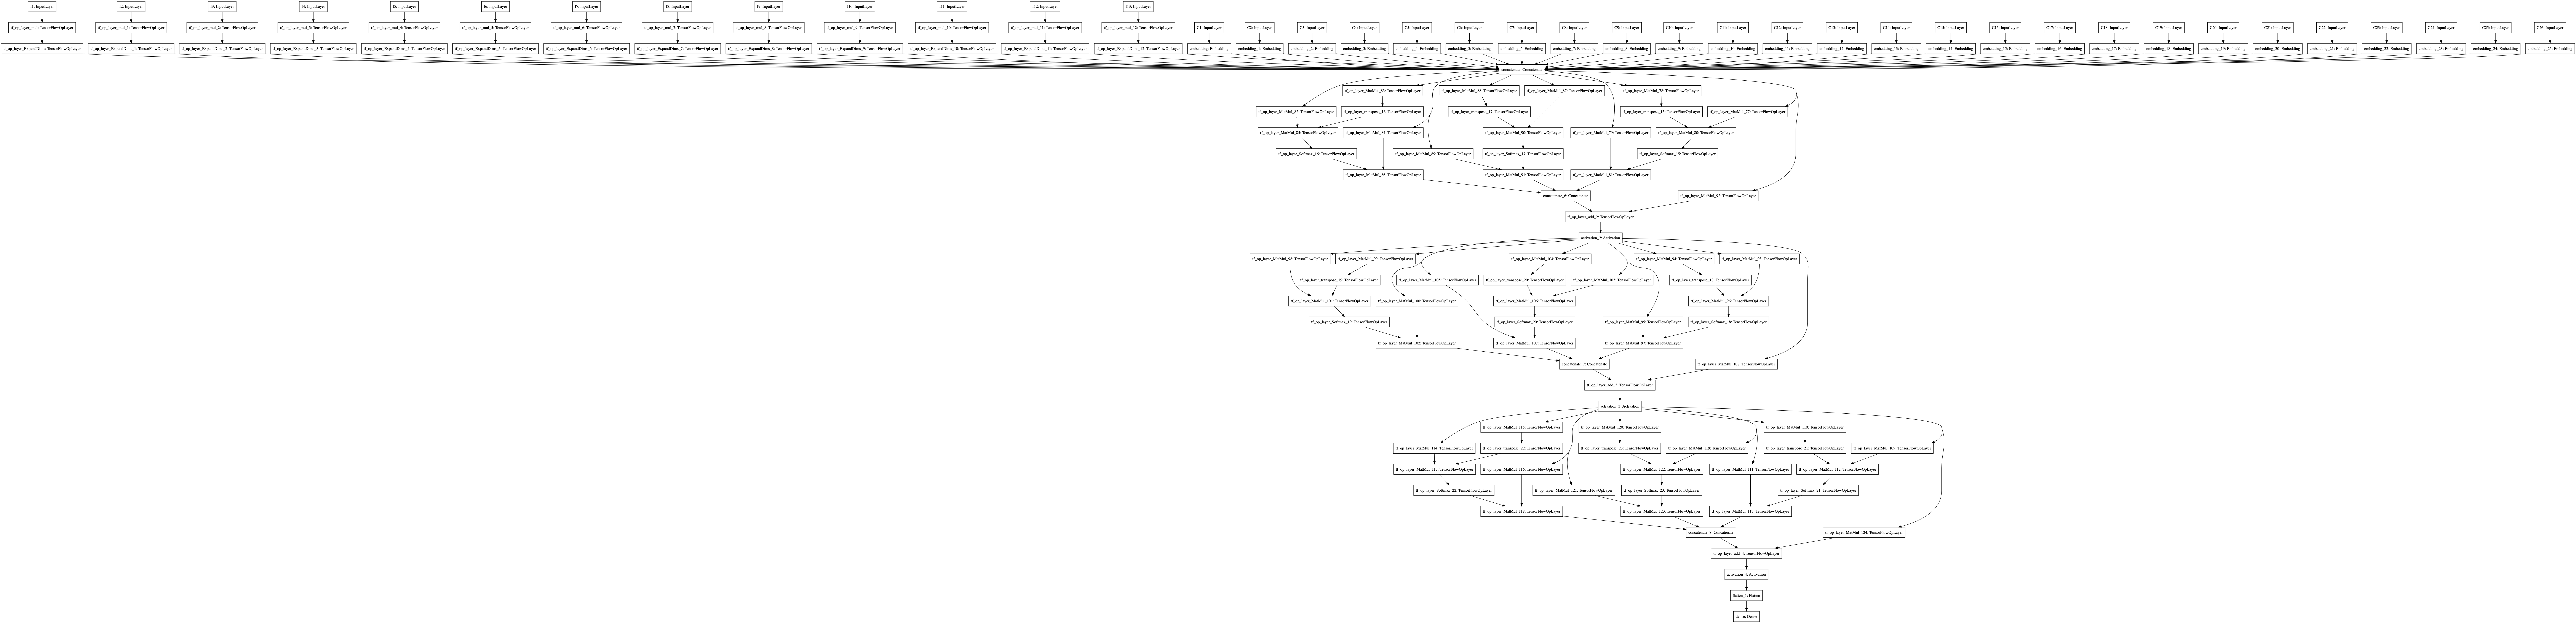

In [42]:
plot_model(model)

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
I2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
I3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
I4 (InputLayer)                 [(None, 1)]          0                                            
______________________________________________________________________________________________

In [44]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

## 训练

In [45]:
from tensorflow.keras.callbacks import TensorBoard

In [46]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [47]:
valid_data = total_data.loc[500000:]
train_data = total_data.loc[:500000-1]

In [48]:
train_dense_x = [train_data[f].values for f in dense_feats]
train_sparse_x = [train_data[f].values for f in sparse_feats]

In [49]:
train_label = [train_data['label'].values]

In [50]:
val_dense_x = [valid_data[f].values for f in dense_feats]
val_sparse_x = [valid_data[f].values for f in sparse_feats]

In [51]:
val_label = [valid_data['label'].values]

In [52]:
model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=5, batch_size=256,
          validation_data=(val_dense_x+val_sparse_x, val_label), 
          callbacks=[tbCallBack])

Train on 500000 samples, validate on 100000 samples
Epoch 1/5


/Users/Nelson/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/Nelson/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500000/500000 [==============================] - 217s 435us/sample - loss: 21.6491 - binary_crossentropy: 0.5041 - auc: 0.7276 - val_loss: 0.6305 - val_binary_crossentropy: 0.5084 - val_auc: 0.7300
Epoch 2/5
500000/500000 [==============================] - 228s 456us/sample - loss: 0.6401 - binary_crossentropy: 0.4966 - auc: 0.7388 - val_loss: 0.6624 - val_binary_crossentropy: 0.5010 - val_auc: 0.7364
Epoch 3/5
500000/500000 [==============================] - 241s 481us/sample - loss: 0.6643 - binary_crossentropy: 0.4952 - auc: 0.7410 - val_loss: 0.6865 - val_binary_crossentropy: 0.5083 - val_auc: 0.7364
Epoch 4/5
500000/500000 [==============================] - 213s 427us/sample - loss: 0.6829 - binary_crossentropy: 0.4940 - auc: 0.7428 - val_loss: 0.6882 - val_binary_crossentropy: 0.5005 - val_auc: 0.7372
Epoch 5/5
500000/500000 [==============================] - 215s 429us/sample - loss: 0.6863 - binary_crossentropy: 0.4934 - auc: 0.7437 - val_loss: 0.7006 - val_binary_crossentropy: